Hello Susan!

I’m happy to review your project today.
I will mark your mistakes and give you some hints how it is possible to fix them. We are getting ready for real job, where your team leader/senior colleague will do exactly the same. Don't worry and study with pleasure! 

Below you will find my comments - **please do not move, modify or delete them**.

You can find my comments in green, yellow or red boxes like this:

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Success. Everything is done succesfully.
</div>

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Remarks. Some recommendations.
</div>

<div class="alert alert-block alert-danger">

<b>Reviewer's comment</b> <a class="tocSkip"></a>

Needs fixing. The block requires some corrections. Work can't be accepted with the red comments.
</div>

You can answer me by using this:

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

Text

</div>

# Interconnect: Forecasting Churn

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it is discovered that a user is planning to leave, they will be offered promotional codes and special plan options. This company provides two types of services: landline communication and internet. The company also provides some other services such as internet security,
a dedicated technical support line, cloud file storage and data backup, and TV streaming and a movie directory. The clients can choose either a monthly payment or sign a 1- or 2-year contract.

The data consists of files obtained from different sources:

 - contract.csv — contract information
 - personal.csv — the client's personal data
 - internet.csv — information about Internet services
 - phone.csv — information about telephone services

In each file, the column customerID contains a unique code assigned to each client.

Our target feature is the EndDate column, and the primary metric is AUC-ROC.

##  Initialization and Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [5]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [6]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [7]:
#check for duplicates
print(contract.duplicated().sum())
print(personal.duplicated().sum())
print(internet.duplicated().sum())
print(phone.duplicated().sum())

0
0
0
0


In [8]:
contract['BeginDate'].sort_values()

4513    2013-10-01
4610    2013-10-01
3439    2013-10-01
975     2013-11-01
3040    2013-11-01
           ...    
3331    2020-02-01
6670    2020-02-01
936     2020-02-01
3826    2020-02-01
6754    2020-02-01
Name: BeginDate, Length: 7043, dtype: object

In [9]:
contract['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

In [10]:
# find percentage of how many customers have not churned
len(contract[contract['EndDate'] == 'No']) / len(contract['EndDate']) * 100

73.4630129206304

There are no missing values or duplicates in our datasets. 73% of the customers have not ended their service, so the classes of the target feature are unbalanced.

## Preprocessing

1. Merge the datasets into one DataFrame.
2. Change column names to lowercase with underscores.
3. Change data types: begin_date to datetime, total_charge to float64.
4. Convert yes/no columns to contain ones and zeros.

In [11]:
#merge the datasets on the customerID column
data = contract.merge(personal, on='customerID', how='outer')
data = data.merge(internet, on='customerID', how='outer')
data = data.merge(phone, on='customerID', how='outer')

In [12]:
#fill in missing values created from merging
data = data.fillna('No')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


In [13]:
#change column names to lowercase with underscores
def camel_to_snake(name):
    # Handles acronyms like ID and TV properly
    name = re.sub(r'(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.lower()

data.columns = [camel_to_snake(col) for col in data.columns]

In [14]:
#change begin_date columm to datetime data type
data['begin_date'] = pd.to_datetime(data['begin_date'], format='%Y-%m-%d')
data['begin_date'].head()

0   2020-01-01
1   2017-04-01
2   2019-10-01
3   2016-05-01
4   2019-09-01
Name: begin_date, dtype: datetime64[ns]

In [15]:
#change total_charges to float64 data type
data['total_charges'] = pd.to_numeric(data['total_charges'], errors='coerce')

In [16]:
data['total_charges'].isna().sum()

11

In [17]:
#fill missing values with zeros
data['total_charges'] = data['total_charges'].fillna(0)

In [18]:
#convert yes and no values to 1 and 0
cols_to_convert = ['paperless_billing', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

data[cols_to_convert] = data[cols_to_convert].apply(lambda col: col.str.lower().map({'no': 0, 'yes': 1}))

In [19]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85,Female,0,1,0,DSL,0,1,0,0,0,0,0
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.50,Male,0,0,0,DSL,1,0,1,0,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0,DSL,1,1,0,0,0,0,0
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,0,0,DSL,1,0,1,1,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0,Fiber optic,0,0,0,0,0,0,0


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   int64         
 11  dependents         7043 non-null   int64         
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   int64         
 14  online_b

## Feature Engineering

1. Apply One-Hot Encoding to remaining categorical columns.
2. Extract features from the begin_date column.
3. Transform end_date values to 0 for those who have not churned and 1 for those who have ended their service.
4. Delete customer_id and begin_date columns.

In [21]:
#One-Hot Encoding
ohe_cols = ['type', 'payment_method', 'gender', 'internet_service']

dummies = pd.get_dummies(data[ohe_cols], drop_first=True)

data = data.drop(columns=ohe_cols)
data=pd.concat([data, dummies], axis=1)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   customer_id                             7043 non-null   object        
 1   begin_date                              7043 non-null   datetime64[ns]
 2   end_date                                7043 non-null   object        
 3   paperless_billing                       7043 non-null   int64         
 4   monthly_charges                         7043 non-null   float64       
 5   total_charges                           7043 non-null   float64       
 6   senior_citizen                          7043 non-null   int64         
 7   partner                                 7043 non-null   int64         
 8   dependents                              7043 non-null   int64         
 9   online_security                         7043 non-nul

In [23]:
data['end_date'] = data['end_date'].apply(lambda x: 0 if str(x).lower() == 'no' else 1)
data['end_date']

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: end_date, Length: 7043, dtype: int64

In [24]:
#extract features from the begin_date column
data['begin_year'] = data['begin_date'].dt.year
data['begin_month'] = data['begin_date'].dt.month
data['begin_day'] = data['begin_date'].dt.day

In [25]:
#remove columns not useful for the models
data = data.drop(columns=['customer_id', 'begin_date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   end_date                                7043 non-null   int64  
 1   paperless_billing                       7043 non-null   int64  
 2   monthly_charges                         7043 non-null   float64
 3   total_charges                           7043 non-null   float64
 4   senior_citizen                          7043 non-null   int64  
 5   partner                                 7043 non-null   int64  
 6   dependents                              7043 non-null   int64  
 7   online_security                         7043 non-null   int64  
 8   online_backup                           7043 non-null   int64  
 9   device_protection                       7043 non-null   int64  
 10  tech_support                            7043 non-null   int6

## Split Data into Training and Test Sets

1. Separate features from the target
2. Use train_test_split to split 25% of the data into a test set

In [26]:
#separate features and target
X = data.drop(columns='end_date')
y = data['end_date']

In [27]:
#split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Balance Classes

1. The target classes are imbalanced, so we will upsample the minority class to even out the data.
2. Scale the data using StandardScaler()

In [28]:
#combine X and y for upsampling
train_data = pd.concat([X_train, y_train], axis=1)

#split classes
majority = train_data[train_data['end_date'] == 0]
minority = train_data[train_data['end_date'] == 1]

print("Number of observations for customers who have not churned:", majority.shape[0])
print("Number of observations for customers who have churned:", minority.shape[0])

Number of observations for customers who have not churned: 3892
Number of observations for customers who have churned: 1390


In [29]:
#upsample minority class
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)

#combine classes and shuffle
upsampled = pd.concat([majority, minority_upsampled])
upsampled = shuffle(upsampled, random_state=42)
upsampled.shape

(7784, 25)

In [30]:
#separate target and features
X_train_upsampled = upsampled.drop(columns='end_date', axis=1)
y_train_upsampled = upsampled['end_date']

In [31]:
#scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_upsampled)
X_test_scaled = scaler.transform(X_test)

## Model Training

1. Train Logistic Regression, XGBoost, LightGBM, and CatBoost models.
2. Collect the evaluation metrics of each model.

In [32]:
#initialize a Logistic Regression model as a baseline model
base_model = LogisticRegression()
base_model.fit(X_train_scaled, y_train_upsampled)

y_proba = base_model.predict_proba(X_test_scaled)[:, 1]
base_roc_auc = roc_auc_score(y_test, y_proba)
print(f'ROC AUC score for base model:', base_roc_auc)

ROC AUC score for base model: 0.8563342116148112


In [33]:
#collect evaluation metrics
model_metrics = []

y_proba = base_model.predict_proba(X_test_scaled)[:, 1]
y_pred = base_model.predict(X_test_scaled)
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba)

model_metrics.append({
    'Model': 'Logistic Regression',
    'ROC AUC': base_roc_auc,
    'Accuracy': accuracy_score(y_test, y_pred),
    'FPR': fpr_base,
    'TPR': tpr_base
})

In [34]:
#XGBoost Model
#define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
}

#initialize model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

#tune hyperparameters
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring='roc_auc',
    n_iter=30,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train_upsampled)
best_xgb_model = random_search.best_estimator_
best_xgb_params = random_search.best_params_

print("Best XGBoost parameters:", best_xgb_params)
print("XGBoost ROC AUC score:", random_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best XGBoost parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2}
XGBoost ROC AUC score: 0.9841330936002498


In [35]:
#collect XGBoost metrics

y_proba_xgb = best_xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred_xgb = best_xgb_model.predict(X_test_scaled)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

model_metrics.append({
    'Model': 'XGBoost',
    'ROC AUC': roc_auc_score(y_test, y_proba_xgb),
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'FPR': fpr_xgb,
    'TPR': tpr_xgb
})

In [36]:
#LightGBM Model
lgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [15, 31, 63],
    'max_depth': [-1, 5, 10, 20],
}

light_model = lgb.LGBMClassifier(random_state=42)

lgb_search = RandomizedSearchCV(
    estimator=light_model,
    param_distributions=lgb_params,
    scoring='roc_auc',
    n_iter=30,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

lgb_search.fit(X_train_scaled, y_train_upsampled)

best_light_model = lgb_search.best_estimator_
best_light_params = lgb_search.best_params_

print("Best LightGBM parameters:", best_light_params)
print("LightGBM ROC AUC score:", lgb_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best LightGBM parameters: {'num_leaves': 63, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.2}
LightGBM ROC AUC score: 0.9854209128302783


In [37]:
#collect LightGBM metrics

y_proba_light = best_light_model.predict_proba(X_test_scaled)[:, 1]
y_pred_light = best_light_model.predict(X_test_scaled)
fpr_light, tpr_light, _ = roc_curve(y_test, y_proba_light)

model_metrics.append({
    'Model': 'LightGBM',
    'ROC AUC': roc_auc_score(y_test, y_proba_light),
    'Accuracy': accuracy_score(y_test, y_pred_light),
    'FPR': fpr_light,
    'TPR': tpr_light
})

In [38]:
#CatBoost Model

cat_params = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0, 1, 2],
    'random_strength': [1, 5, 10]
}

cat_model = CatBoostClassifier(verbose=0, random_state=42, eval_metric='AUC')

cat_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=cat_params,
    scoring='roc_auc',
    n_iter=30,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

cat_search.fit(X_train_scaled, y_train_upsampled)

best_cat_model = cat_search.best_estimator_
best_cat_params = cat_search.best_params_

print("Best CatBoost parameters:", best_cat_params)
print("CatBoost ROC AUC score:", cat_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best CatBoost parameters: {'random_strength': 1, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 300, 'depth': 10, 'border_count': 64, 'bagging_temperature': 2}
CatBoost ROC AUC score: 0.9810288015334404


In [1]:
#collect CatBoost metrics

y_proba_cat = best_cat_model.predict_proba(X_test_scaled)[:, 1]
y_pred_cat = best_cat_model.predict(X_test_scaled)
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_proba_cat)

model_metrics.append({
    'Model': 'CatBoost',
    'ROC AUC': roc_auc_score(y_test, y_proba_cat),
    'Accuracy': accuracy_score(y_test, y_pred_cat),
    'FPR': fpr_cat,
    'TPR': tpr_cat
})

NameError: name 'best_cat_model' is not defined

## Model Testing Results

1. Create a table summarizing the ROC AUC and Accuracy scores of each model.
2. Plot the ROC curves of each model.

In [40]:
#create a summary table
summary = pd.DataFrame(model_metrics)[['Model', 'ROC AUC', 'Accuracy']]
summary.sort_values(by='ROC AUC', ascending=False, inplace=True)
print(summary)

                 Model   ROC AUC  Accuracy
2             LightGBM  0.932373  0.885292
1              XGBoost  0.932114  0.888132
3             CatBoost  0.918504  0.873367
0  Logistic Regression  0.856334  0.749006


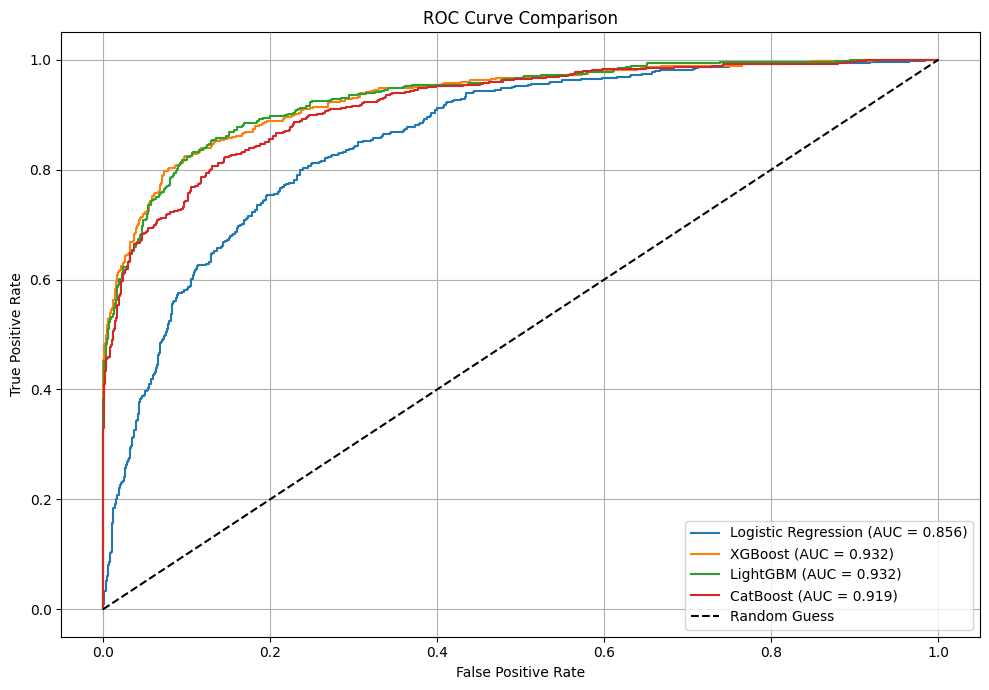

In [41]:
#plot ROC Curves
plt.figure(figsize=(10, 7))

for entry in model_metrics:
    plt.plot(entry['FPR'], entry['TPR'], label=f"{entry['Model']} (AUC = {entry['ROC AUC']:.3f})")
    
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

All of the models performed very well. The Logistic Regression had a ROC AUC score of 0.856, and all of the other models were quite a bit higher. The LightGBM and XGBoost performed the best and had minimal differences in the ROC AUC and accuracy scores, but LightGBM did slightly outperform the XGBoost. This is the model we recommend Interconnect use to predict the churn of their customers.

## Conclusion

The telecom company Interconnect would like to forecast the churn of their clients. We were provided with data from their customers that included contract, personal, internet, and phone information.

**Initial analysis:** We performed an initial analysis of the data and found that we had no missing values, but there was an imbalance of the classes where 73% of the observations were still active clients.

**Data Preprocessing:** We cleaned the column names to be a uniform lowercase with underscores. Then, we changed the datatypes of the begin_date column to datetime and the total_charge column to float64. We also converted the columns with yes and no values to contain 1 and 0 values.

**Feature Engineering:** We used One-Hot Encoding on the remaining categorical columns. Then, we extracted features from the begin_date column. We deleted the customer_id and begin_date columns, as they would not be useful in our models.

**Train and Test Sets:** We separated our features and our target and then used train_test_split to split the data into training and test sets.

**Balance Classes:** Because the classes in our target were imbalanced, we upsampled the minority class in our training set to even them out. Then we used StandardScaler to scale the features.

**Model Training:** We trained Logistic Regression, XGBoost, LightGBM, and CatBoost models. Then, we tested and collected the evaluation metrics from each model. We were interested in the ROC AUC score and the accuracy scores.

**Results:** We found that all of the models performed very well. The LightGBM and XGBoost both had the highest ROC AUC and accuracy scores, but LightGBM slightly outperformed XGBoost. Therefore, we recommend that Interconnect use the LightGBM model to forecast the churn of their clients.


<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

You did a great job! But you have one problem. You have a target leakage here and thus you got such impressive results. If we know begin_year, begin_month and begin_day we can easily calculate begin_date, right? If we know begin_date and len_of_service we can easily restore end_date, right? If we know end_date, we can easily restore our target. If we can do it, any good ML model can do it as well. And this is exactly what happened in your project. You can use begin_year, begin_month and begin_day or you can use len_of_service but you can't use all these features together.

</div>

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

Thank you. I first tried removing the begin_year, begin_month, and begin_day, and the results ended with the Logistic Regression as the best model. When I removed the len_of_service and used begin_year, begin_month, and begin_day, the results were much better.
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Everything is correct now. Well done! Based on your roc-auc score you achieved 6.0/6.0 sp. Not many students manage to achieve such a high quality model.

Good luck with your new job search!

</div>